## Train GPT on images

Effectively re-implements OpenAI's [Image GPT](https://openai.com/blog/image-gpt/) model, getting GPT to model images instead of text, but using a near identical model. It's truly quite remarkable that a single model can agnostically do a great job modeling whatever data you give it: text, images, or whatever else. At the end of the day it is just a sequence of integers. Notice that unlike models like PixelCNN++ etc, this model knows nothing at all about the spatial layout of the pixels and has to learn the appropriate positional embeddings that reflect the spatial topology of the data.

In [ ]:
!git clone https://github.com/karpathy/minGPT.git
%cd minGPT
!pip install trains

fatal: destination path 'minGPT' already exists and is not an empty directory.
/content/minGPT


In [ ]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from trains import Task
colab_task = Task.init(project_name='minGPT',task_name='test play_image')

TRAINS Task: overwriting (reusing) task id=9f41c971b45c4c0c93a4f7472b1cd1b9
TRAINS results page: https://demoapp.trains.allegro.ai/projects/27f1be9a79a549778b4e655eb3231572/experiments/9f41c971b45c4c0c93a4f7472b1cd1b9/output/log


In [ ]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [ ]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [ ]:
# pytorch helpfully makes it easy to download datasets, e.g. the common CIFAR-10 https://www.kaggle.com/c/cifar-10
root = './'
data = torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=True)
print(len(data))

Files already downloaded and verified
50000


Images are represented as array of size (height, width, 3), where is the RGB values, each is a uint8 in range 0..255. In CIFAR-10 for example, the height and width are both 32. 

**naive strategy**
Now, to feed images into GPT we have to somehow turn every image into a sequence of integers. Since each image is 32\*32\*3 = 3072 uint8s, in principle we could just flatten each image out into a 3072-long sequence of numbers from 0..255 and train GPT on that. Note that we are free to feed this into GPT in any random arbitrary order, as long as the encoding order is fixed for all images. The problem with this is that GPT gets very expensive as you grow the sequence size, since each new predicted integer is a function of all previously predicted integers in the sequence, and the attention inside the Transformer modules gets very expensive.

**k-means codebook strategy**
Instead, the Image GPT strategy is to encode every individual RGB pixel into a codebook of 512 entries, which we train via the k-means clustering algorithm. This way, we only have a 32\*32 = 1024-long sequence, but now of integers in the range 0..511. This is a net saving in compute because we're "shrunk" the sequence length by a factor of 3. On the other hand, our token encoding embedding parameters grow a bit in size, as well as the size of the Softmax classifier at the end.

Okay let's train our codebook with k-means now

In [ ]:
# get random 5 pixels per image and stack them all up as rgb values to get half a million random pixels
px = torch.cat([torch.from_numpy(np.array(x)).view(32*32, 3)[torch.randperm(32*32)[:5], :] for x, y in data], dim=0).float()
print(px.size())

torch.Size([250000, 3])


In [ ]:
# run kmeans to get our codebook

def kmeans(x, ncluster, niter=10):
    N, D = x.size()
    c = x[torch.randperm(N)[:ncluster]] # init clusters at random
    for i in range(niter):
        # assign all pixels to the closest codebook element
        a = ((x[:, None, :] - c[None, :, :])**2).sum(-1).argmin(1)
        # move each codebook element to be the mean of the pixels that assigned to it
        c = torch.stack([x[a==k].mean(0) for k in range(ncluster)])
        # re-assign any poorly positioned codebook elements
        nanix = torch.any(torch.isnan(c), dim=1)
        ndead = nanix.sum().item()
        print('done step %d/%d, re-initialized %d dead clusters' % (i+1, niter, ndead))
        c[nanix] = x[torch.randperm(N)[:ndead]] # re-init dead clusters
    return c

ncluster = 128 # was 512

with torch.no_grad():
    C = kmeans(px, ncluster, niter=8)

print(C.size())

done step 1/8, re-initialized 0 dead clusters
done step 2/8, re-initialized 0 dead clusters
done step 3/8, re-initialized 0 dead clusters
done step 4/8, re-initialized 0 dead clusters
done step 5/8, re-initialized 0 dead clusters
done step 6/8, re-initialized 0 dead clusters
done step 7/8, re-initialized 0 dead clusters
done step 8/8, re-initialized 0 dead clusters
torch.Size([128, 3])


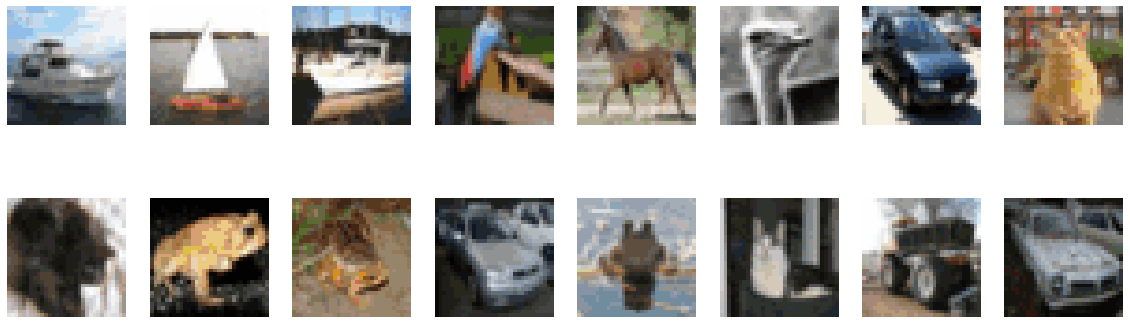

In [ ]:
# encode the training examples with our codebook to visualize how much we've lost in the discretization
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    
    # encode and decode random data
    x, y = data[np.random.randint(0, len(data))]
    xpt = torch.from_numpy(np.array(x)).float().view(32*32, 3)
    ix = ((xpt[:, None, :] - C[None, :, :])**2).sum(-1).argmin(1) # cluster assignments for each pixel
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(C[ix].view(32, 32, 3).numpy().astype(np.uint8))
    plt.axis('off')

The images above look relatively reasonable, so our 512-sized codebook is enough to reasonably re-represent RGB values. Ok cool. So now every image is just a 3072-long sequence of numbers between 0..511. Time to train a GPT.

In [ ]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into sequences of integers
    """
    
    def __init__(self, pt_dataset, clusters, perm=None):
        self.pt_dataset = pt_dataset
        self.clusters = clusters
        self.perm = torch.arange(32*32) if perm is None else perm
        
        self.vocab_size = clusters.size(0)
        self.block_size = 32*32 - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1, 3) # flatten out all pixels
        x = x[self.perm].float() # reshuffle pixels with any fixed permutation and -> float
        a = ((x[:, None, :] - self.clusters[None, :, :])**2).sum(-1).argmin(1) # cluster assignments
        return a[:-1], a[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(data, C)
train_dataset[0][0] # one example image flattened out into integers

tensor([109, 102,  21,  ...,   2,  28,  16])


For reference, **iGPT-S** from the paper is:
- batch size of 128 and trained for 1M terations
- Adam lr 0.003 with betas = (0.9, 0.95)
- learning rate is warmed up for one epoch, then decays to 0
- did not use weight decay or dropout
- `n_layer=24, n_head=8, n_embd=512`

We will do something similar but slightly smaller, by about a half.

In [ ]:
from mingpt.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
# AJB: much smaller for the colab:
n_head = 4 # was 8
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=12, n_head=n_head, n_embd=256)
model = GPT(mconf)

08/23/2020 19:05:18 - INFO - mingpt.model -   number of parameters: 9.805056e+06


In [ ]:
from mingpt.trainer import Trainer, TrainerConfig

"""
Note that I am running on an 8-GPU V100 machine so each GPU has 32GB.
If you don't have as many computational resources you have to bring down
the batch_size until the model fits into your memory, and then you may
also need to adjust the learning rate (e.g. decrease it a bit). Alternatively,
you can use an even smaller model up above, bringing down the number of layers,
number of heads, and the embedding size.
"""

tokens_per_epoch = len(data) * train_dataset.block_size
train_epochs = 10 # way too little tbh, i'm just impatient. todo: run longer later

# initialize a trainer instance and kick off training
n = 1 # was 8
lr = 3e-3 / 8.0 * n # unscale learning rate because of batch size change
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=16*n, learning_rate=lr,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      num_workers=4)


In [ ]:
colab_task.connect_configuration(vars(mconf),name='model_config')
colab_task.connect_configuration(vars(tconf),name='trainer_config')

{'batch_size': 16,
 'betas': (0.9, 0.95),
 'final_tokens': 511500000,
 'learning_rate': 0.000375,
 'lr_decay': True,
 'max_epochs': 10,
 'num_workers': 4,
 'warmup_tokens': 51150000,
 'weight_decay': 0}

In [ ]:
import gc
gc.collect() 
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

epoch 1 iter 2: train loss 4.87664. lr 3.600000e-07:   0%|          | 3/3125 [02:14<40:02:38, 46.18s/it]

TRAINS Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


epoch 1 iter 3: train loss 4.72661. lr 4.800000e-07:   0%|          | 4/3125 [02:56<38:53:06, 44.85s/it]

TRAINS Monitor: Reporting detected, reverting back to iteration based reporting


epoch 1 iter 86: train loss 4.46912. lr 1.044000e-05:   3%|▎         | 87/3125 [1:00:53<35:28:20, 42.03s/it]

In [ ]:
# to sample we also have to technically "train" a separate model for the first token in the sequence
# we are going to do so below simply by calculating and normalizing the histogram of the first token
counts = torch.ones(ncluster) # start counts as 1 not zero, this is called "smoothing"
rp = torch.randperm(len(train_dataset))
nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[int(rp[i])]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

In [ ]:
%%time

from mingpt.utils import sample

n_samples = 32
start_pixel = np.random.choice(np.arange(C.size(0)), size=(n_samples, 1), replace=True, p=prob)
start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
pixels = sample(model, start_pixel, 32*32-1, temperature=1.0, sample=True, top_k=None)

In [ ]:
# for visualization we have to invert the permutation used to produce the pixels
iperm = torch.argsort(train_dataset.perm)

ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    pxi = pixels[i][iperm] # note: undo the encoding permutation
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(C[pxi].view(32, 32, 3).numpy().astype(np.uint8))
    plt.axis('off')

In [ ]:
# visualize some of the learned positional embeddings, maybe they contain structure
plt.figure(figsize=(10, 10))
nsee = 8*8
ncol = 8
nrow = nsee // ncol
for i in range(nsee):
    
    ci = model.pos_emb.data[0, :, i].cpu()
    zci = torch.cat((torch.tensor([0.0]), ci)) # pre-cat a zero
    rzci = zci[iperm] # undo the permutation to recover the pixel space of the image
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(rzci.view(32, 32).numpy())
    plt.axis('off')

In [ ]:
# huh, pretty cool! :P